Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/Skin-cancer/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Skin-cancer/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Train dataset
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Validation dataset
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

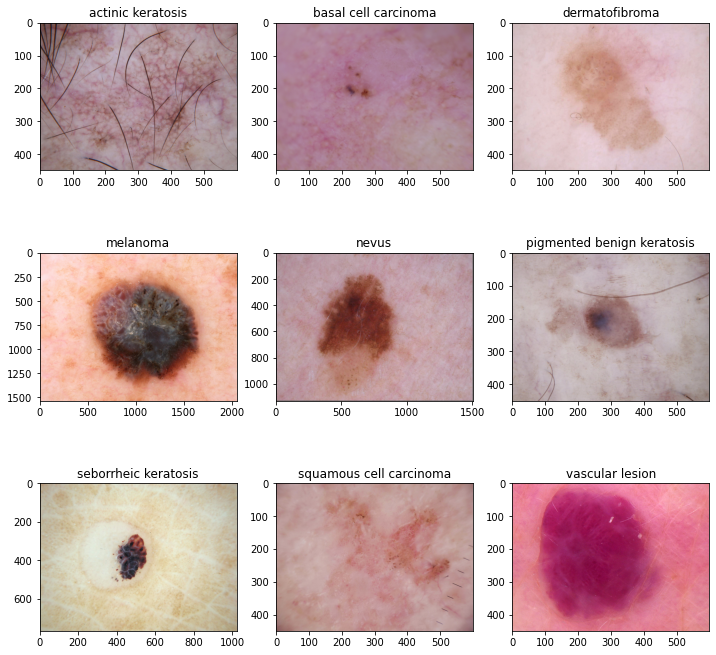

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
### Choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 262s 977ms/step - loss: 2.0649 - accuracy: 0.2015 - val_loss: 2.0105 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 4s 77ms/step - loss: 1.9532 - accuracy: 0.2595 - val_loss: 1.8025 - val_accuracy: 0.3445
Epoch 3/20
56/56 [==============================] - 4s 77ms/step - loss: 1.8632 - accuracy: 0.2946 - val_loss: 1.8359 - val_accuracy: 0.2975
Epoch 4/20
56/56 [==============================] - 4s 78ms/step - loss: 1.7315 - accuracy: 0.3633 - val_loss: 1.6190 - val_accuracy: 0.4116
Epoch 5/20
56/56 [==============================] - 4s 78ms/step - loss: 1.6127 - accuracy: 0.4057 - val_loss: 1.6169 - val_accuracy: 0.4362
Epoch 6/20
56/56 [==============================] - 4s 78ms/step - loss: 1.5750 - accuracy: 0.4314 - val_loss: 1.6603 - val_accuracy: 0.4139
Epoch 7/20
56/56 [==============================] - 4s 78ms/step - loss: 1.5855 - accuracy: 0.4224 - val_loss: 1.5517 - val_accuracy: 0.4362
Epoch 8/20
56/56 [===

### Visualizing training results

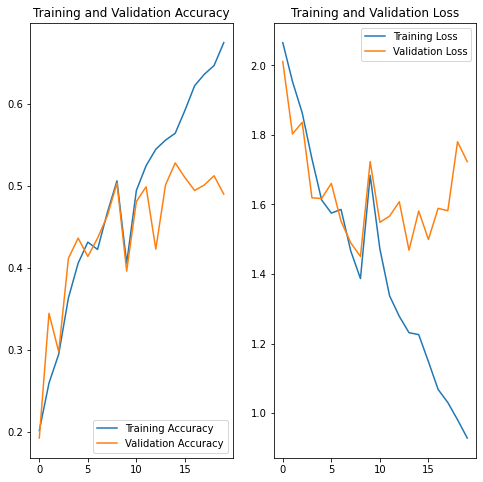

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Finding on first model:

* The model is overfitting as there is difference in the training and test results.
* Accuracy is around 70%

In [17]:
# After you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

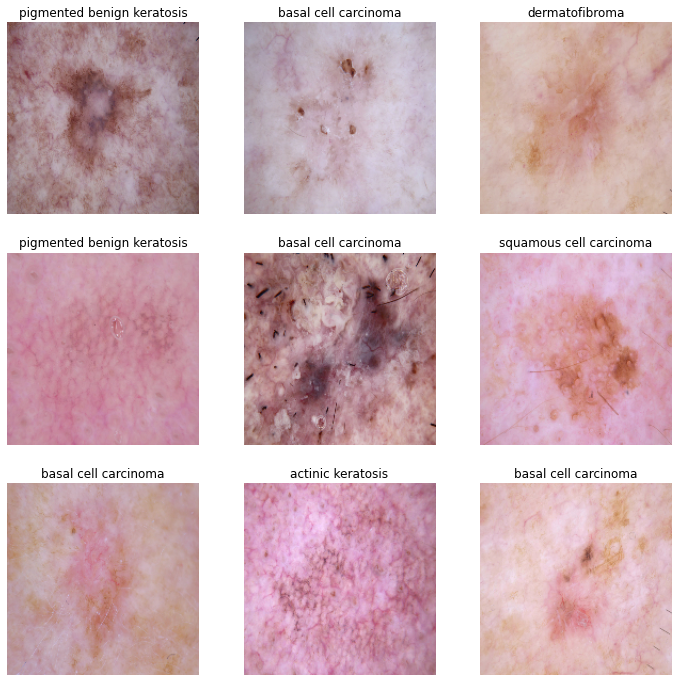

In [18]:
# Visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


### Create the model, compile and train the model


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compiling the model

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [21]:
## Note: train your model for 20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 7s 92ms/step - loss: 2.0552 - accuracy: 0.1987 - val_loss: 1.9380 - val_accuracy: 0.2841
Epoch 2/20
56/56 [==============================] - 5s 86ms/step - loss: 1.9264 - accuracy: 0.2640 - val_loss: 1.9156 - val_accuracy: 0.2528
Epoch 3/20
56/56 [==============================] - 5s 87ms/step - loss: 1.8715 - accuracy: 0.2879 - val_loss: 1.7793 - val_accuracy: 0.3244
Epoch 4/20
56/56 [==============================] - 5s 89ms/step - loss: 1.8503 - accuracy: 0.3058 - val_loss: 1.7992 - val_accuracy: 0.3244
Epoch 5/20
56/56 [==============================] - 5s 87ms/step - loss: 1.7894 - accuracy: 0.3276 - val_loss: 1.7467 - val_accuracy: 0.3803
Epoch 6/20
56/56 [==============================] - 5s 87ms/step - loss: 1.6937 - accuracy: 0.3867 - val_loss: 1.6616 - val_accuracy: 0.3848
Epoch 7/20
56/56 [==============================] - 5s 87ms/step - loss: 1.6065 - accuracy: 0.4247 - val_loss: 1.5156 - val_accuracy: 0.4720
Epoch 8/20
56/56 [======

### Visualizing the results

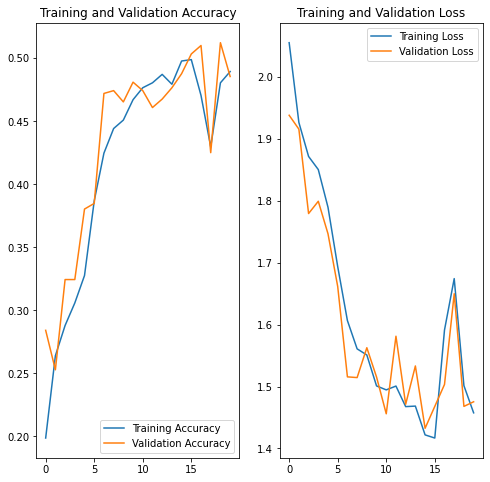

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### Finding: 
* Accuracy has dropped.
* Overfitting issue is resolved, post using dropouts.



#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_new = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/Skin-cancer/Train/actin...,actinic keratosis
1,/content/drive/MyDrive/Skin-cancer/Train/actin...,actinic keratosis
2,/content/drive/MyDrive/Skin-cancer/Train/actin...,actinic keratosis
3,/content/drive/MyDrive/Skin-cancer/Train/actin...,actinic keratosis
4,/content/drive/MyDrive/Skin-cancer/Train/actin...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Skin-cancer/Train/vascu...,vascular lesion
2235,/content/drive/MyDrive/Skin-cancer/Train/vascu...,vascular lesion
2236,/content/drive/MyDrive/Skin-cancer/Train/vascu...,vascular lesion
2237,/content/drive/MyDrive/Skin-cancer/Train/vascu...,vascular lesion


In [24]:
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

<BarContainer object of 9 artists>

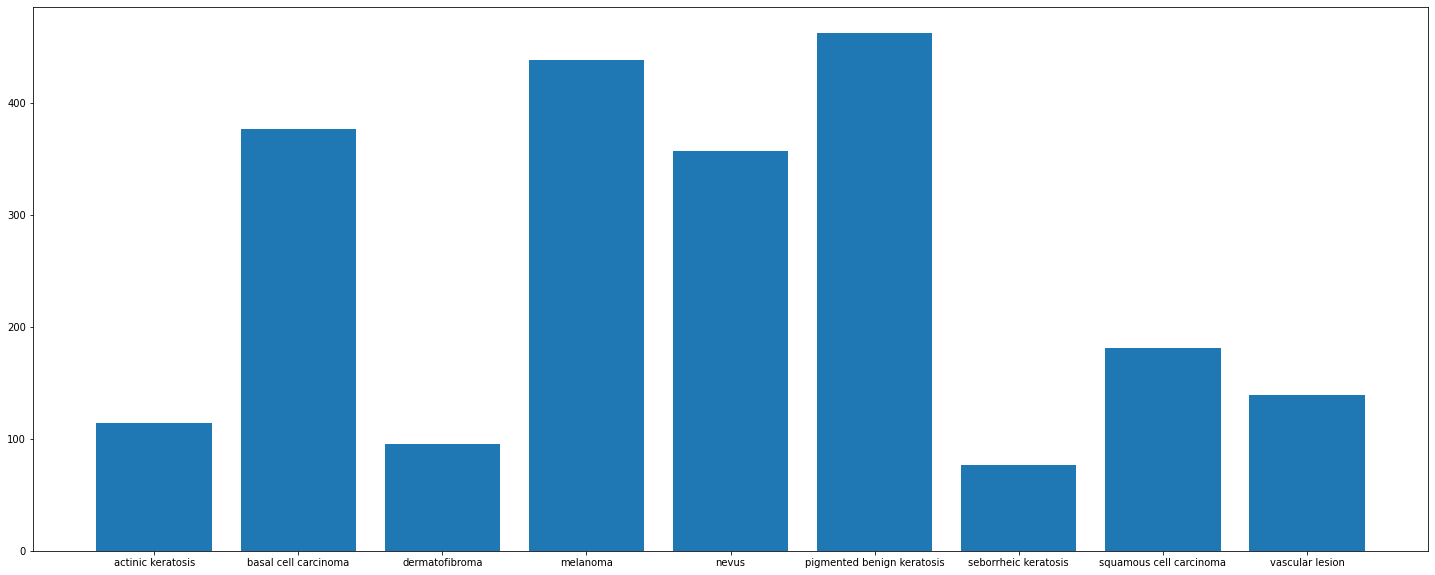

In [25]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

In [26]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

#### **Todo:** Write your findings here: 
#### 1. Which class has the least number of samples?
* seborrheic keratosis has least number of samples
#### 2. Which classes dominate the data in terms proportionate number of samples?
* actinic keratosis and dermatofibroma
* melanoma and pigmented benign keratosis 
* basal cell carcinoma and nevus

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [32]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [33]:
path_to_training_dataset="/content/drive/MyDrive/Skin-cancer/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset +i )
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Skin-cancer/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F968E4DE3D0>: 100%|██████████| 500/500 [00:22<00:00, 22.67 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Skin-cancer/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F969109AE50>: 100%|██████████| 500/500 [00:23<00:00, 21.47 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Skin-cancer/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9692AF2C90>: 100%|██████████| 500/500 [00:22<00:00, 21.79 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Skin-cancer/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9710088E10>: 100%|██████████| 500/500 [01:45<00:00,  4.74 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Skin-cancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7F9692AF2BD0>: 100%|██████████| 500/500 [01:38<00:00,  5.07 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Skin-cancer/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F97BAFA3710>: 100%|██████████| 500/500 [00:21<00:00, 23.79 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Skin-cancer/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9692453350>: 100%|██████████| 500/500 [00:45<00:00, 11.06 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Skin-cancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F96911831D0>: 100%|██████████| 500/500 [00:19<00:00, 25.68 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Skin-cancer/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9724914AD0>: 100%|██████████| 500/500 [00:19<00:00, 25.65 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [34]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [35]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/Skin-cancer/Train/nevus/output/nevus_original_ISIC_0000541.jpg_44600f30-5b9c-4b0f-a2cf-14fcf8db0efc.jpg',
 '/content/drive/MyDrive/Skin-cancer/Train/nevus/output/nevus_original_ISIC_0000243.jpg_9dd19ede-c3a5-4ecd-83c5-b130d7f3546f.jpg',
 '/content/drive/MyDrive/Skin-cancer/Train/nevus/output/nevus_original_ISIC_0000373.jpg_998d1359-ae29-4cf6-a624-92a91efd9fd3.jpg',
 '/content/drive/MyDrive/Skin-cancer/Train/nevus/output/nevus_original_ISIC_0000065.jpg_4876e5cc-2ac1-4a53-af4b-d75770af0fd1.jpg',
 '/content/drive/MyDrive/Skin-cancer/Train/nevus/output/nevus_original_ISIC_0024763.jpg_e328905b-b803-4e54-8ac8-65c91370557e.jpg',
 '/content/drive/MyDrive/Skin-cancer/Train/nevus/output/nevus_original_ISIC_0000262.jpg_2bbbdb03-7164-4016-95db-feed940c289e.jpg',
 '/content/drive/MyDrive/Skin-cancer/Train/nevus/output/nevus_original_ISIC_0000341.jpg_a1cbed5d-34fc-432f-ac36-987278dbd99f.jpg',
 '/content/drive/MyDrive/Skin-cancer/Train/nevus/output/nevus_original_ISIC_0025368

In [36]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [37]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [38]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [39]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [40]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [41]:
data_dir_train1=pathlib.Path("/content/drive/MyDrive/Skin-cancer/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 10 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [42]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 10 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [43]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ 
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [44]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [45]:
epochs =50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


281/281 [==============================] - 58s 200ms/step - loss: nan - accuracy: 0.0554 - val_loss: nan - val_accuracy: 0.0534
Epoch 2/50
281/281 [==============================] - 54s 189ms/step - loss: nan - accuracy: 0.0549 - val_loss: nan - val_accuracy: 0.0534
Epoch 3/50
281/281 [==============================] - 53s 184ms/step - loss: nan - accuracy: 0.0549 - val_loss: nan - val_accuracy: 0.0534
Epoch 4/50
281/281 [==============================] - 53s 184ms/step - loss: nan - accuracy: 0.0549 - val_loss: nan - val_accuracy: 0.0534
Epoch 5/50
281/281 [==============================] - 53s 184ms/step - loss: nan - accuracy: 0.0549 - val_loss: nan - val_accuracy: 0.0534
Epoch 6/50
281/281 [==============================] - 54s 189ms/step - loss: nan - accuracy: 0.0549 - val_loss: nan - val_accuracy: 0.0534
Epoch 7/50
281/281 [==============================] - 53s 183ms/step - loss: nan - accuracy: 0.0549 - val_loss: nan - val_accuracy: 0.0534
Epoch 8/50
281/281 [==================

#### **Todo:**  Visualize the model results

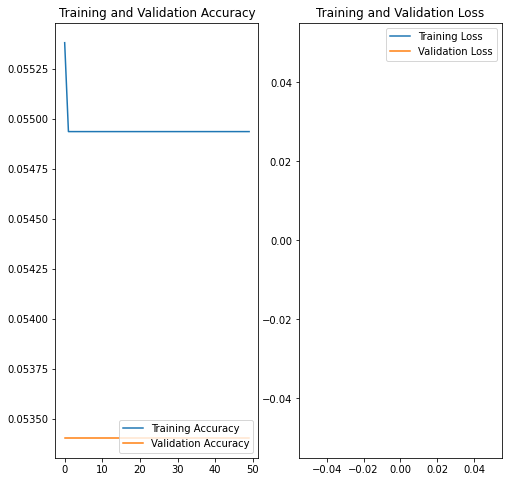

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



* Model is still overfitting
* The problem of overfitting can be solved by adding more layers,neurons.
* Tuning the hyperparameter